In [35]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [36]:
INPUT_PATH = "C:\\Users\\varma\\Desktop\\Combine\\Combine"

In [37]:
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    
    for f in os.listdir(INPUT_PATH +"/"+ dir_ ):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

angry has 4953 number of images
disgust has 547 number of images
fear has 5121 number of images
happy has 8989 number of images
neutral has 6198 number of images
sad has 6077 number of images
surprise has 4002 number of images

total images are 35887


In [38]:
TOP_EMOTIONS = ["happy", "neutral", "sad"]
total_images -= 14623
total_images

21264

In [39]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH +"/"+ dir_ ):
            img_arr[i] = cv2.imread(INPUT_PATH +"/"+ dir_ +"/"+ f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all happy images to numpy arrays
loaded all neutral images to numpy arrays
loaded all sad images to numpy arrays


((21264, 48, 48, 3), array([0., 0., 0., ..., 2., 2., 2.]))

In [40]:
label_to_text

{0: 'happy', 1: 'neutral', 2: 'sad'}

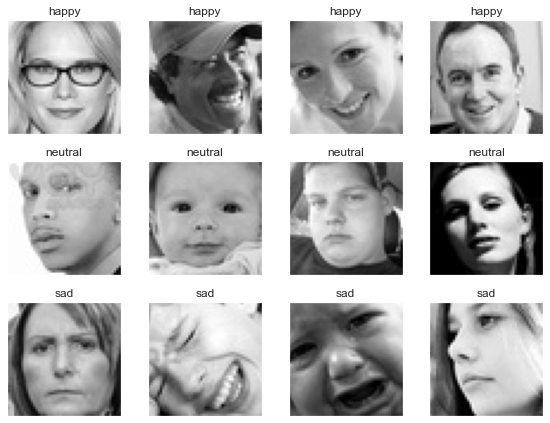

In [41]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [42]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(21264, 3)

In [43]:
img_arr = img_arr / 255.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19137, 48, 48, 3), (2127, 48, 48, 3), (19137, 3), (2127, 3))

In [45]:
del img_arr
del img_label

In [46]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [47]:
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

In [48]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [49]:
for layer in model.layers[:15]:
    layer.trainable = False

In [50]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [51]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [52]:
batch_size = 35
epochs = 35

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)


history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
#     use_multiprocessing=True
)

Epoch 1/35
547/546 [==============================] - 107s 196ms/step - loss: 1.0366 - accuracy: 0.5451 - val_loss: 0.9498 - val_accuracy: 0.6328
Epoch 2/35
547/546 [==============================] - 107s 196ms/step - loss: 0.7474 - accuracy: 0.6609 - val_loss: 0.7166 - val_accuracy: 0.6831curacy
Epoch 3/35
547/546 [==============================] - 106s 193ms/step - loss: 0.6908 - accuracy: 0.6917 - val_loss: 0.6761 - val_accuracy: 0.7029
Epoch 4/35
547/546 [==============================] - 106s 194ms/step - loss: 0.6747 - accuracy: 0.7039 - val_loss: 0.6300 - val_accuracy: 0.7170
Epoch 5/35
547/546 [==============================] - 105s 193ms/step - loss: 0.6436 - accuracy: 0.7173 - val_loss: 0.7611 - val_accuracy: 0.6432
Epoch 6/35
547/546 [==============================] - 106s 194ms/step - loss: 0.6371 - accuracy: 0.7250 - val_loss: 0.6471 - val_accuracy: 0.7170
Epoch 7/35
547/546 [==============================] - 85s 156ms/step - loss: 0.6319 - accuracy: 0.7299 - val_loss: 0.7

In [54]:
model_yaml = model.to_json()
with open("model_mobelnet.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_moblenet.h5")






F:\anaconda3\envs\MachineLearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
F:\anaconda3\envs\MachineLearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
F:\anaconda3\envs\MachineLearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.w

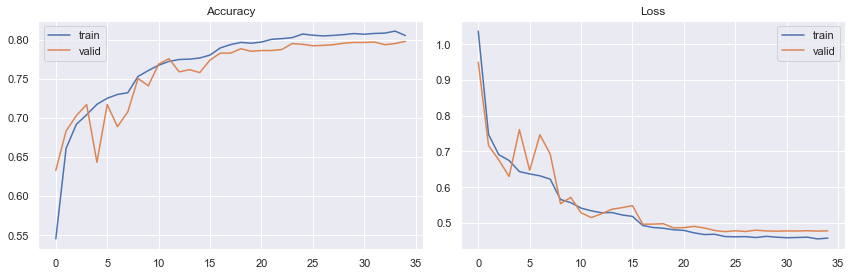

In [55]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()

In [56]:
label_to_text

{0: 'happy', 1: 'neutral', 2: 'sad'}

In [57]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'happy': 0, 'neutral': 1, 'sad': 2}

test accuracy: 79.7837 %


              precision    recall  f1-score   support

           0       0.93      0.90      0.91       899
           1       0.68      0.73      0.70       620
           2       0.73      0.72      0.73       608

    accuracy                           0.80      2127
   macro avg       0.78      0.78      0.78      2127
weighted avg       0.80      0.80      0.80      2127



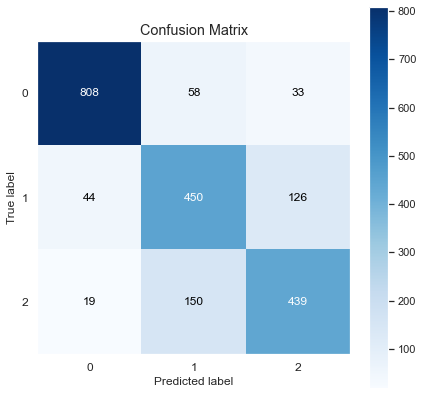

In [58]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

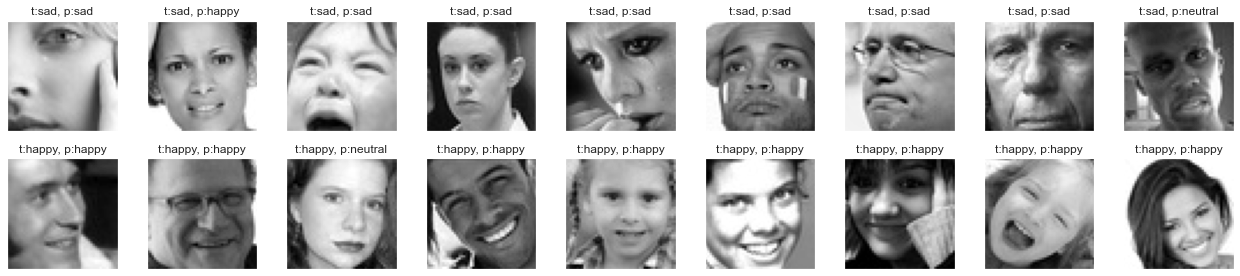

In [60]:
np.random.seed(42)
sad_imgs = np.random.choice(np.where(y_test[:, text_to_label["sad"]]==1)[0], size=9, replace=False)
happy_imgs = np.random.choice(np.where(y_test[:, text_to_label["happy"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (sad_idx, happy_idx) in enumerate(zip(sad_imgs, happy_imgs)):
        sample_img = X_test[sad_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:sad, p:{pred}")

        sample_img = X_test[happy_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:happy, p:{pred}")

        pyplot.tight_layout()